In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from torch.autograd import Variable

from __future__ import unicode_literals, print_function, division
from io import open
import string
import random
import re

import numpy as np
from collections import Counter
import os
from argparse import Namespace

# Hyperparameters
RANDOM_SEED = 1
filename_path = '...'

torch.manual_seed(RANDOM_SEED)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open(filename_path, 'r') as f:
    file_ = f.read()
file_len = len(file_)
print('file_len =', file_len)

file_len = 91481


In [0]:
chunk_len = 200

def random_chunk():
    start_index = np.random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file_[start_index:end_index]

print(len(random_chunk()))

201


In [0]:
all_characters = 'аәбвгғдеёжзийкқлмнңоөпрстуұүфхһцчшщъыіьэюяАӘБВГҒДЕЁЖЗИЙКҚЛМНҢОӨПРСТУҰҮФХҺЦЧШЩЪЫІЬЭЮЯ—!"#$%&\' ()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'
n_characters = len(all_characters)
n_characters

124

In [0]:
class RNNPoem(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers = 1, dropout=0.5):
      super(RNNPoem, self).__init__()

      self.hidden_size = hidden_size
      self.input_size = input_size
      self.output_size = output_size
      self.n_layers = n_layers

      self.drop = nn.Dropout()
      self.embedding = nn.Embedding(input_size, hidden_size)
      self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
      self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self, inputs, hidden):
      seq_len = len(inputs)
      input_ = self.embedding(inputs).view(1, -1)
      output, hidden = self.rnn(input_.view(1, 1, -1), hidden)
      output = self.decoder(output.view(1,-1))
      return output, hidden

  def init_hidden(self):
      return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
            Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))

In [0]:

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('лмнңоө—'))

tensor([15, 16, 17, 18, 19, 20, 84])


In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [0]:
a, b = random_training_set()
print(b.size())

torch.Size([200])


In [0]:
def evaluate(prime_str='К', predict_len=100, temperature=0.7):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p].unsqueeze(0), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp.unsqueeze(0), hidden)
        
        # Sample from the network as a multinomial distribution
        #output_dist = F.softmax(output.data.view(1,-1))
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].unsqueeze(0), hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [0]:
n_epochs = 5000
print_every = 150
plot_every = 20
hidden_size = 512
n_layers = 1
lr = 0.005

decoder = RNNPoem(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()
    loss = train(inp, target)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('К', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


 59s (150 3%) 2.1116]
Кер жалмай.
Қашын тағаның қуан көрнеді
Алпамарын жалаптас едің көрімен құй олмандар.
Бат мен алайт,
Қ 

 2s (300 6%) 1.8977]
Көйлетіп жоқ,
Сондай тұрған салақ балай,
Бір етке жүр ұшанал бетір,
Бір еді дер құшады.
Келі жылай та 

 5s (450 9%) 1.8373]
Көңлін алдық бұлар еді:
"Бір жаста мін, қарақ ақтай,
Ашуған береді.
Осыр бар адап,
Алпамысқан кел бол 

 6s (600 12%) 1.8300]
Көреміз болып келді.
Жарды жаттардай.
Ырзатқан тілемінің
Ырзарам толып барып ұрды,
Жаяғын көңіледі.
Қ 

 6s (750 15%) 1.6783]
Көріп барасып,
Бұлат қалмақ балады
Қалмақ сонда көріп басып,
Көңлі ем қолды сұлын,
Жерді бала барада  

 7s (900 18%) 1.9773]
Көзің күйді үйдіріп,
Қаһар жап-тықта келкі келді.
Аузын сұрып, жай-қалып,
Құдамын бұл қылмас бе?
Байб 

 7s (1050 21%) 1.6035]
Көзі өзіме,
Тайшық дәуіріп жасында
Бұрғанда өліп үйретіп,
Қандай екі денді келіп жас болама,
Қызған к 

 12s (1200 24%) 1.5276]
Келім барады.
Айналайым, жаның
Жерті ердің Алпамыс батта
Қарайған ты қойын
Кейқуат өркен, жан, 

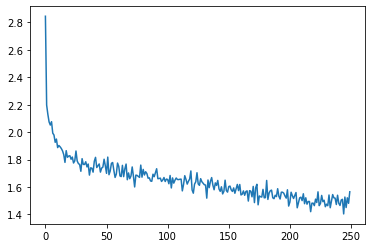

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
def save_checkpoint(state, filename='checkpointAlpa.pt'):
    torch.save(state, filename)

save_checkpoint({
            'epoch': n_epochs + 1,
            'state_dict': decoder.state_dict(),
            'optimizer' : decoder_optimizer.state_dict(),
        })

In [0]:
x = 'аәбвгғдеёжзийкқлмнңоөпрстуұүфхһцчшщъыіiьэюяАӘБВГҒДЕЁЖЗИЙКҚЛМНҢОӨПРСТУҰҮФХҺЦЧШЩЪЫІIЬЭЮЯ—!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

print(evaluate('Дат', 200, temperature=0.3))

Датындар бар арнағын,
Жамырайды, білмейді не боларын.
- Кеш, аруақ,- деп,- тентекті.- жалынады.
Жаудырады иманын, тобаларын.
Артқан қамыс тірліктің белгісі боп,
Демеу жасап, жылымға бергісі жоң.
Ақ айдын


In [0]:
print(evaluate('Қалың мал', 500, temperature=0.6))


Қалың малының бәрі де бір жаратылға да беріпті. Бұл елдің тұрған алғын, мұранып жүрген де жаратқандығың бірі жоқ жері қарай тағала тағала қалай алмайды, надандық ол - қай ме? Жоқ болғанды мақтаншақтығы бас беріп, бітпей қылып жүрінің атының бір ойлап кетпей қалады, не айтса да, менің көріп, не алла тағалаға ғылымда артық болады. Бұл адаләттан ұялмайын деп көріп ұяты көңіліне қайтып, көңіліне жаратқа терістіп, мұны біліншілік та қылады. Оның бәрі - де жолда болмайды. Оның мақтары мақтаншақ келетіп кетсін 
